### Preparing the env dependencies

In [ ]:
import warnings
import kagglehub
import spacy
import string
import re
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from kagglehub import KaggleDatasetAdapter
from wordcloud import WordCloud
from collections import Counter
from sklearn import metrics
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization
warnings.simplefilter("ignore")

### Load the latest version of dataset

In [11]:
def getting_datasets(kaggle_paths, online=False):
  datasets = []
  for path, name, columns in kaggle_paths:
    save_path = f"data/{name}"
    try:
        if online:
            df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, path, name)
            df.to_csv(save_path, encoding='utf-8', index=False)
        else:
            df = pd.read_csv(save_path)
        df = df[columns]
        df = df.rename(columns={columns[0]: "resume", columns[1]: "category"})
        df.drop_duplicates()
        print(save_path, df)
        datasets.append(df)
    except:
      print("Error loading dataset", path, name)
      continue
  return datasets

In [12]:
kaggle_paths = [
    ("surendra365/recruitement-dataset", "job_applicant_dataset.csv", ["Resume", "Job Roles"]),
    ("jithinjagadeesh/resume-dataset", "gpt_dataset.csv", ["Resume", "Category"]),
    ("gauravduttakiit/resume-dataset", "UpdatedResumeDataSet.csv", ["Resume", "Category"]),
    ("snehaanbhawal/resume-dataset", "Resume/Resume.csv", ["Resume_str", "Category"]),
    ("noorsaeed/resume-datasets", "clean_resume_data.csv", ["Feature", "Category"]),
]
datasets = getting_datasets(kaggle_paths)

data/job_applicant_dataset.csv                                                  resume              category
0     Proficient in Injury Prevention, Motivation, N...         Fitness Coach
1     Proficient in Healthcare, Pharmacology, Medica...             Physician
2     Proficient in Forecasting, Financial Modelling...     Financial Analyst
3     Proficient in Budgeting, Supply Chain Optimiza...  Supply Chain Manager
4     Proficient in Logistics, Negotiation, Procurem...  Supply Chain Manager
...                                                 ...                   ...
9995  Proficient in Biology, Regulatory Compliance, ...   Biomedical Engineer
9996  Proficient in Communication, Teamwork, Lesson ...               Teacher
9997  Proficient in Medical Terminology, Critical Th...             Physician
9998  Proficient in Exercise Programming, Motivation...         Fitness Coach
9999  Proficient in Content Strategy, Copywriting, C...        Content Writer

[10000 rows x 2 columns]
data/gp

### Preprocessing dataset

In [14]:
def clean_text(text):
  text = str(text).lower()  # Convert to lowercase
  text = re.sub(r'\n', ' ', text)  # Remove newlines
  text = re.sub(r'\[.*?\]', '', text)  # Remove text in brackets
  text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
  text = re.sub(r'\w*\d\w*', '', text)  # Remove words with numbers
  text = re.sub(r'https?://\S+|www\.\S+|ftp\.\S+', '', text) # remove ulrs
  text = re.sub(r'\S+@\S+', '', text) # remove emails
  text = re.sub('[^A-Za-z0-9 ]+', '', text) # no special character but space
  text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
  return text.strip()

nlp = spacy.load('en_core_web_sm')
def remove_stopwords(text):
  doc = nlp(text)
  tokens = [token.text for token in doc if not token.is_stop]
  return ' '.join(tokens)

def lemmatizing(text):
  doc = nlp(text)
  lemmatized_tokens = [token.lemma_ for token in doc]
  return ' '.join(lemmatized_tokens)

def cleaning_datasets(datasets, columns):
  for i, df in enumerate(datasets):
    for col in columns:
      df[col] = df[col].apply(clean_text)
      df[col] = df[col].apply(remove_stopwords)
      df[col] = df[col].apply(lemmatizing)
    df = df.drop_duplicates()
    df.to_csv(f"data/filtered/df_{i}.csv", encoding='utf-8', index=False)
  return datasets

In [ ]:
text_columns = ['resume', 'category']
clean_df = cleaning_datasets(datasets, text_columns)

all_data = pd.concat(clean_df, ignore_index=True)
all_data = all_data.drop_duplicates()
all_data.to_csv('data/filtered/data_clean.csv', encoding='utf-8', index=False)
all_data.shape

Catching off-line data

In [2]:
# after that I ask to gemini to generate new data for categories with less count
all_data = pd.read_csv("data/filtered/normalized.csv")
all_data = all_data.dropna()
all_data = all_data.drop_duplicates()
all_data.shape

(18240, 2)

### Data Mining

Word of clouds

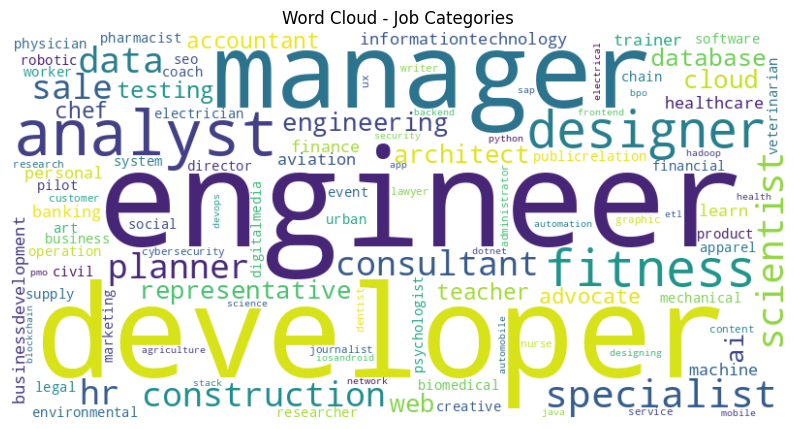

In [41]:
categories = " ".join(all_data['category'].values)
wordcloud_categories = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(categories)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_categories, interpolation='bilinear')
plt.title("Word Cloud - Job Categories")
plt.axis('off')
plt.show()

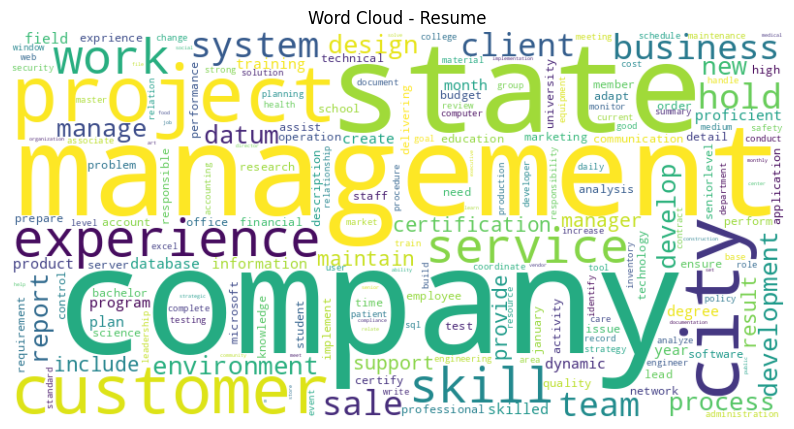

In [42]:
resumes_words = " ".join(all_data['resume'].values)
wordcloud_resumes = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(resumes_words)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_resumes, interpolation='bilinear')
plt.title("Word Cloud - Resume")
plt.axis('off')
plt.show()

Resume instances for each job category

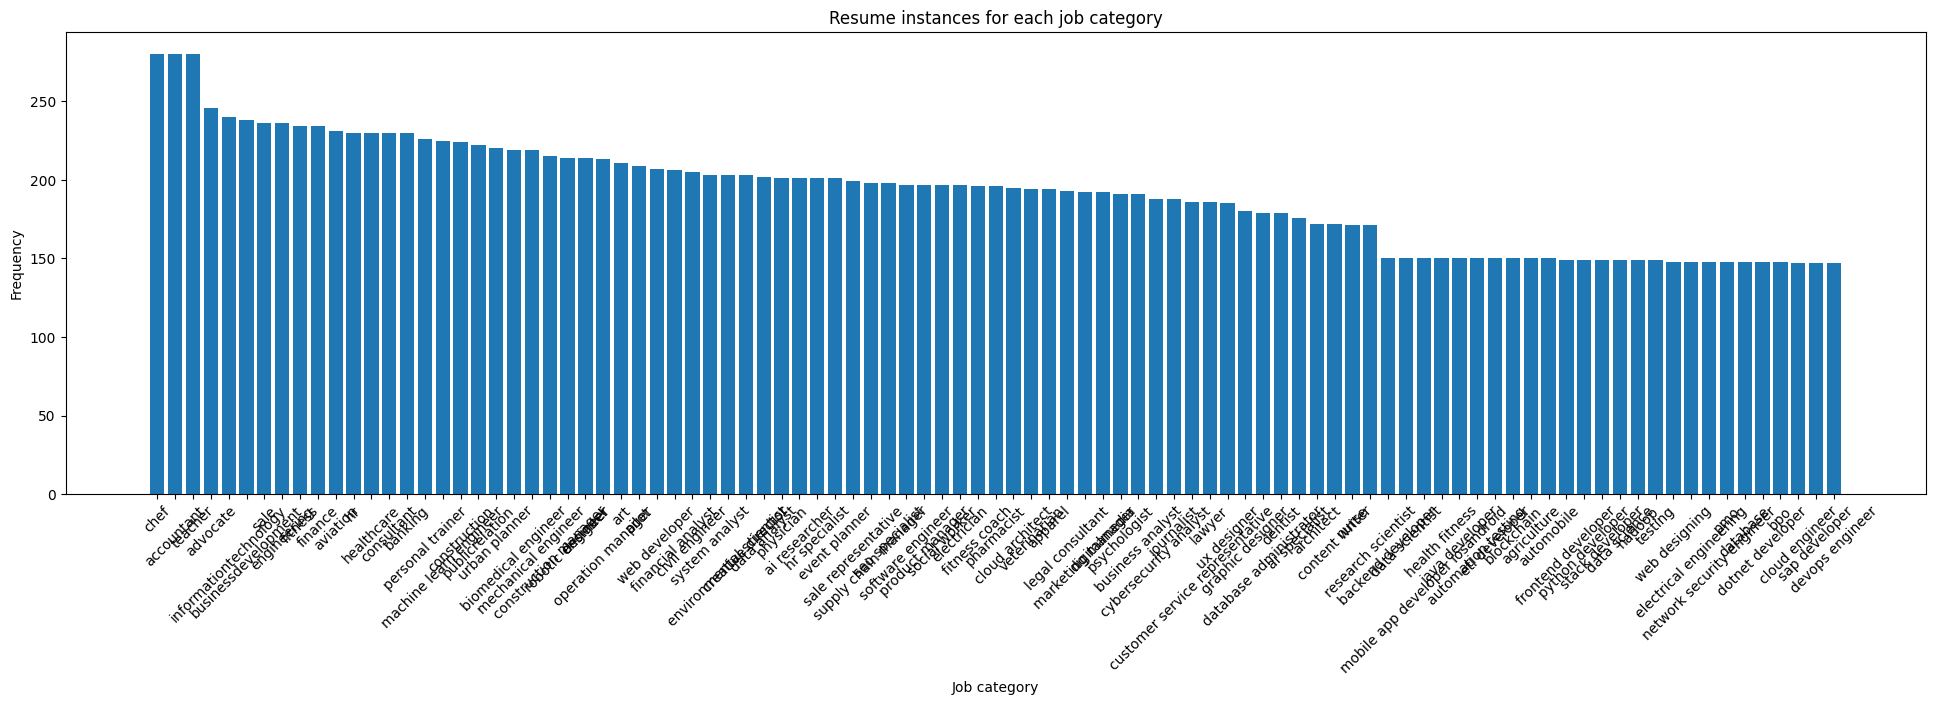

In [43]:
category_counts = Counter(all_data['category'])
common_words = category_counts.most_common(len(category_counts))
words, counts = zip(*common_words)

plt.figure(figsize=(24, 6))
plt.bar(words, counts)
plt.title("Resume instances for each job category")
plt.xlabel("Job category")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

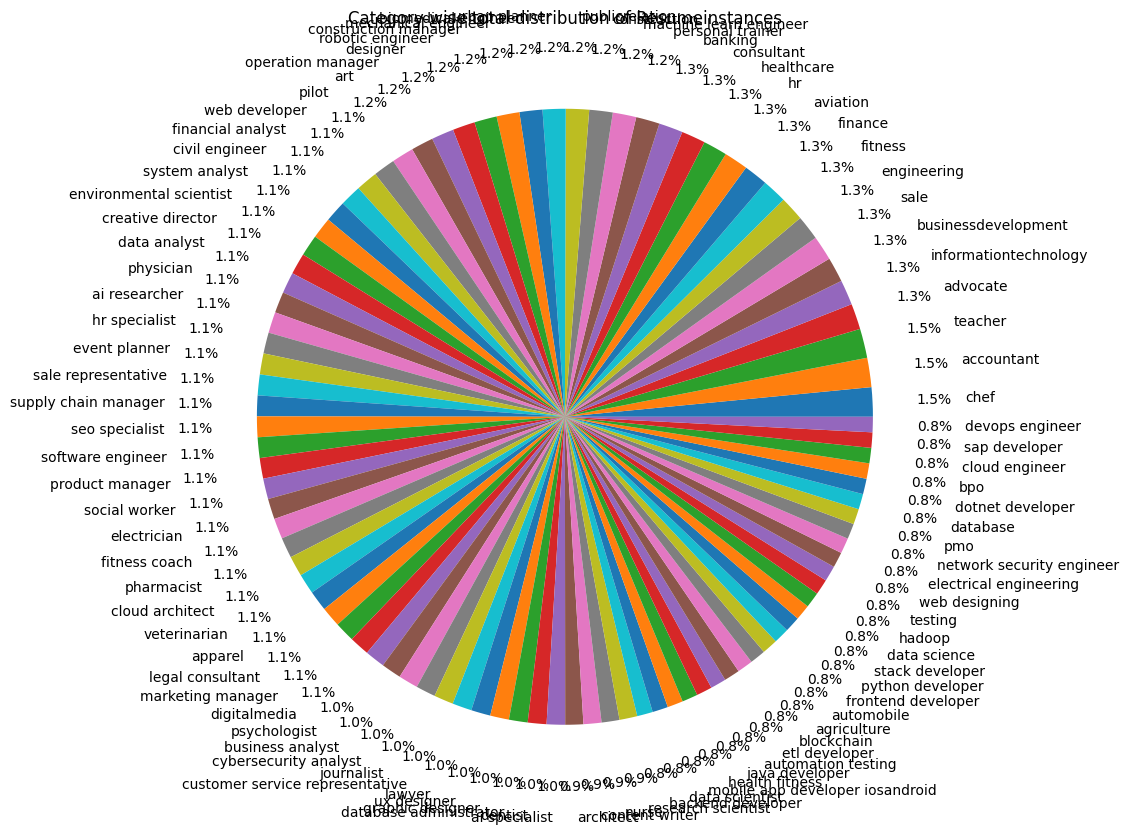

In [44]:
sizes = [c/len(category_counts) for c in counts]

plt.figure(figsize=(20, 10))
plt.pie(sizes, labels=words, autopct='%1.1f%%', pctdistance=1.2, labeldistance=1.3)
plt.title("Category-wise total distribution of Resumeinstances")
plt.show()

In [45]:
category_tb = pd.DataFrame({'job category': words, 'count': counts, 'sizes (%)': sizes})
category_tb

,job category,count,sizes (%)
0,chef,280,2.947368
1,accountant,280,2.947368
2,teacher,280,2.947368
3,advocate,246,2.589474
4,informationtechnology,240,2.526316
...,...,...,...
90,dotnet developer,148,1.557895
91,bpo,148,1.557895
92,cloud engineer,147,1.547368
93,sap developer,147,1.547368


### Vectorizer

#### Label Encoder

In [23]:
def encode_labels(categories):
    label_encoder = LabelEncoder()
    category_encoded = label_encoder.fit_transform(categories)
    print(category_encoded)
    num_categories = len(label_encoder.classes_)
    y = to_categorical(category_encoded)
    return label_encoder, y, num_categories

def decoded_label(label_encoder, y_encoded, categorical=True):
    label = [int(np.argmax(y)) for y in y_encoded] if categorical else y_encoded
    return label_encoder.inverse_transform(label)

In [4]:
categories = all_data['category']
label_encoder, y, num_categories = encode_labels(categories)
print(num_categories, y)

[48 70 46 ... 72 72 72]
95 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### TF-IDF

In [5]:
tfidf_vec = TfidfVectorizer()
resumes_vec = tfidf_vec.fit_transform(all_data['resume'])
inputs = len(tfidf_vec.get_feature_names_out())
print("Tamanho:", len(tfidf_vec.get_feature_names_out()), "Vocabulário:", tfidf_vec.get_feature_names_out(), )
resumes_vec

Tamanho: 48295 Vocabulário: ['aa' 'aaa' 'aaacom' ... 'zyvox' 'zz' 'zzxzx']


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2122670 stored elements and shape (18240, 48295)>

In [6]:
X_train_vec, X_temp_vec, y_train_vec, y_temp_vec = train_test_split(resumes_vec, y, test_size=0.3, random_state=42)
X_val_vec, X_test_vec, y_val_vec, y_test_vec = train_test_split(X_temp_vec, y_temp_vec, test_size=0.5, random_state=42)
X_train_vec.shape, X_temp_vec.shape, X_val_vec.shape, X_test_vec.shape

((12768, 48295), (5472, 48295), (2736, 48295), (2736, 48295))

#### Tokens

In [7]:
num_words = 20000
max_length = 1000
token = Tokenizer(num_words=num_words, oov_token="<OOV>")
token.fit_on_texts(all_data['resume'])
inputs = len(token.word_index)
resumes_token = token.texts_to_sequences(all_data['resume'])
resumes_token = pad_sequences(resumes_token, padding="post", truncating="post", maxlen=max_length)
inputs, resumes_token

(48319,
 array([[  34, 1307, 1032, ...,    0,    0,    0],
        [  34,  350, 2123, ...,    0,    0,    0],
        [  34,  769,   59, ...,    0,    0,    0],
        ...,
        [   9,  621,   61, ...,    0,    0,    0],
        [ 154,  307,  602, ...,    0,    0,    0],
        [ 154,  307,  602, ...,    0,    0,    0]], dtype=int32))

In [8]:
X_train_tkn, X_temp_tkn, y_train_tkn, y_temp_tkn = train_test_split(resumes_token, y, test_size=0.3, random_state=42)
X_val_tkn, X_test_tkn, y_val_tkn, y_test_tkn = train_test_split(X_temp_tkn, y_temp_tkn, test_size=0.5, random_state=42)
X_train_tkn.shape, X_temp_tkn.shape, X_val_tkn.shape, X_test_tkn.shape

((12768, 1000), (5472, 1000), (2736, 1000), (2736, 1000))

## Training

In [21]:
result_vec_decoded = decoded_label(label_encoder, y_test_vec)
result_vec_df = pd.DataFrame(result_vec_decoded, columns=['target'])
result_vec_df.to_csv('data/results/tf-idf/results.csv', encoding='utf-8', index=False)

result_tkn_decoded = decoded_label(label_encoder, y_test_tkn)
result_tkn_df = pd.DataFrame(result_tkn_decoded, columns=['target'])
result_tkn_df.to_csv('data/results/token/results.csv', encoding='utf-8', index=False)

In [24]:
def save_results(prediction, model_name, vec='tf-idf', categorical=True):
    filename = f'data/results/{vec}/results.csv'
    result_decoded = decoded_label(label_encoder, prediction, categorical)
    result = pd.read_csv(filename)
    result[model_name] = result_decoded
    result.to_csv(filename, encoding='utf-8', index=False)
    print('Results saved in {}'.format(filename))

### Random Forests

In [25]:
def random_forest_model(X_train, X_test, X_val, y_train, y_test, y_val, vec='tf-idf'):
    y_train_categorical = [int(np.argmax(y)) for y in y_train]
    y_test_categorical = [int(np.argmax(y)) for y in y_test]
    y_val_categorical = [int(np.argmax(y)) for y in y_val]
    rng = np.random.RandomState(0)
    param_grid = {
        'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
        'criterion': ["gini", "entropy"]
    }
    forest = RandomForestClassifier(n_estimators=700, criterion='gini', bootstrap=False)
    rsh = HalvingGridSearchCV(estimator=forest, param_grid=param_grid, random_state=rng, factor=5, n_jobs=-1)
    rsh.fit(X_val, y_val_categorical)
    score = rsh.score(X_test, y_test_categorical)
    print("Score: ", score, "Params:", rsh.best_params_)

    model = RandomForestClassifier(
        n_estimators=rsh.best_params_['n_estimators'],
        criterion=rsh.best_params_['criterion'],
        bootstrap=False
    )

    model.fit(X_val, y_val_categorical)
    model.fit(X_train, y_train_categorical)
    prediction = model.predict(X_test)
    accuracy = accuracy_score(y_test_categorical, prediction)
    save_results(prediction, 'RFC', vec, False)
    print(accuracy)
    print(metrics.classification_report(y_test_categorical, prediction))
    return model, accuracy

In [19]:
model_vec, acc_vec = random_forest_model(X_train_vec, X_test_vec, X_val_vec, y_train_vec, y_test_vec, y_val_vec)

/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/pyth

Score:  0.9057017543859649 Params: {'criterion': 'gini', 'n_estimators': 800}
Results saved in data/results/tf-idf/results.csv
0.966374269005848
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        49
           1       0.95      0.88      0.91        40
           2       1.00      0.91      0.95        23
           3       1.00      1.00      1.00        32
           4       1.00      0.84      0.91        31
           5       0.96      0.77      0.86        31
           6       1.00      1.00      1.00        20
           7       0.91      0.59      0.71        34
           8       0.96      1.00      0.98        22
           9       1.00      1.00      1.00        18
          10       0.97      1.00      0.99        39
          11       1.00      1.00      1.00        34
          12       0.92      0.87      0.89        38
          13       1.00      1.00      1.00        42
          14       1.00      1.00      1.00 

In [26]:
model_tkn, acc_tkn = random_forest_model(X_train_tkn, X_test_tkn, X_val_tkn, y_train_tkn, y_test_tkn, y_val_tkn, 'token')

/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/pyth

Score:  0.5847953216374269 Params: {'criterion': 'gini', 'n_estimators': 600}
Results saved in data/results/token/results.csv
0.7726608187134503
              precision    recall  f1-score   support

           0       0.81      0.45      0.58        49
           1       0.30      0.28      0.29        40
           2       0.78      0.30      0.44        23
           3       0.77      0.84      0.81        32
           4       0.61      0.65      0.62        31
           5       0.67      0.13      0.22        31
           6       0.90      0.90      0.90        20
           7       0.71      0.15      0.24        34
           8       1.00      1.00      1.00        22
           9       1.00      0.72      0.84        18
          10       0.48      0.38      0.43        39
          11       1.00      1.00      1.00        34
          12       0.35      0.24      0.28        38
          13       1.00      0.86      0.92        42
          14       1.00      1.00      1.00 

In [20]:
best_model = model_tkn if acc_tkn > acc_vec else model_vec
filename = 'models/RFC_model.pkl'
joblib.dump(model_vec, filename)
print('Model RF saved in {}'.format(filename))

Model RF saved in models/RFC_model.pkl


### MLP

In [27]:
def MLP_model(X_train, X_test, X_val, y_train, y_test, y_val, vec='tf-idf'):
    param_grid = {
        'hidden_layer_sizes': [(150,100,50), (120,80,40), (100,50,30)],
        'max_iter': [200, 400, 600, 800, 1000],
        'activation': ['relu', 'tanh', 'logistic', 'identity'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.001, 0.05],
        'learning_rate': ['constant','adaptive'],
    }
    model = MLPClassifier(hidden_layer_sizes=50, max_iter=500, learning_rate='adaptive')
    rsh = HalvingGridSearchCV(estimator=model, param_grid=param_grid, factor=5, n_jobs=-1, verbose=2)
    rsh.fit(X_val, y_val)
    grid_predictions = rsh.predict(X_test)
    score = metrics.accuracy_score(y_test, grid_predictions)
    print("Score: ",score, "Params:", rsh.best_params_)

    model = MLPClassifier(
        hidden_layer_sizes=grid_predictions['hidden_layer_sizes'],
        max_iter=grid_predictions['max_iter'],
        activation=grid_predictions['activation'],
        solver=grid_predictions['solver'],
        alpha=grid_predictions['alpha'],
        learning_rate=grid_predictions['learning_rate'],
    )
    model.fit(X_val, y_val)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    accuracy = accuracy_score(y_test, prediction)
    save_results(prediction, 'MLP', vec)
    print(accuracy)
    print(metrics.classification_report(y_test, prediction))
    return model, accuracy

In [28]:
mlp_model_vec, mlp_acc_vec = MLP_model(X_train_vec, X_test_vec, X_val_vec, y_train_vec, y_test_vec, y_val_vec, 'tf-idf')
mlp_model_tkn, mlp_acc_tkn = MLP_model(X_train_tkn, X_test_tkn, X_val_tkn, y_train_tkn, y_test_tkn, y_val_tkn, 'token')
best_mlp_model = mlp_model_tkn if mlp_acc_tkn > mlp_acc_vec else mlp_model_vec

ValueError: y should be a 1d array, got an array of shape (2736, 95) instead.

In [ ]:
filename = 'models/MLP_model.pkl'
joblib.dump(best_model, filename)
print('Model MLP saved in {}'.format(filename))

### BERT Classification

### Word Embedding

In [20]:
embedding_dim=144
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")
model = Sequential([
    Embedding(num_words, embedding_dim, input_length=max_length, name="embedding"),
    GlobalAveragePooling1D(),
    Dense(72, activation='relu'),
    Dropout(0.2),
    Dense(num_categories, activation='softmax')
])

/home/ja1/Faculdade/recpad/hybrid-classification-resumes/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.fit(X_train_tkn, y_train_tkn, epochs=10, batch_size=30, verbose=True, validation_data=(X_test_tkn, y_test_tkn))

Epoch 1/10


/home/ja1/Faculdade/recpad/hybrid-classification-resumes/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:789: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2025-06-21 02:02:24.092383: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_477', 384 bytes spill stores, 384 bytes spill loads

2025-06-21 02:02:24.366730: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_477', 72 bytes spill stores, 72 bytes spill loads

2025-06-21 02:02:24.392954: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in functi

415/426 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0139 - loss: 0.2035

2025-06-21 02:02:27.791461: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_477', 1032 bytes spill stores, 1032 bytes spill loads

2025-06-21 02:02:27.798550: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_477', 384 bytes spill stores, 384 bytes spill loads

2025-06-21 02:02:27.841163: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_778', 8 bytes spill stores, 8 bytes spill loads

2025-06-21 02:02:27.852295: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_477', 276 bytes spill stores, 276 bytes spill loads

2025-06-21 02:02:28.208806: I external

426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0140 - loss: 0.2009

2025-06-21 02:02:31.620508: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_75', 764 bytes spill stores, 764 bytes spill loads



426/426 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.0140 - loss: 0.2006 - val_accuracy: 0.0267 - val_loss: 0.0544
Epoch 2/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0226 - loss: 0.0563 - val_accuracy: 0.0424 - val_loss: 0.0532
Epoch 3/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0249 - loss: 0.0547 - val_accuracy: 0.0435 - val_loss: 0.0521
Epoch 4/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0362 - loss: 0.0533 - val_accuracy: 0.0680 - val_loss: 0.0502
Epoch 5/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0582 - loss: 0.0513 - val_accuracy: 0.1663 - val_loss: 0.0481
Epoch 6/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1152 - loss: 0.0489 - val_accuracy: 0.1912 - val_loss: 0.0460
Epoch 7/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1689 - loss: 0.0462 - val_accuracy: 0.2409 - val_loss: 0.0426
Epoch 8/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2210 - loss: 0.0434 - val_accuracy: 0.2792 - va

In [23]:
loss, accuracy = model.evaluate(X_test_tkn, y_test_tkn)
print("Loss: ", loss, "Accuracy: ", accuracy)

2025-06-21 02:02:49.914889: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_75', 76 bytes spill stores, 76 bytes spill loads

2025-06-21 02:02:49.980938: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_75', 268 bytes spill stores, 268 bytes spill loads

2025-06-21 02:02:50.056769: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_82', 52 bytes spill stores, 52 bytes spill loads

2025-06-21 02:02:50.307152: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_75', 1028 bytes spill stores, 1028 bytes spill loads

2025-06-21 02:02:50.422721: I external/loc

66/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3336 - loss: 0.0371

2025-06-21 02:02:52.242820: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_75', 760 bytes spill stores, 760 bytes spill loads



86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.3318 - loss: 0.0371
Loss:  0.03700545057654381 Accuracy:  0.3260233998298645
